2023-12-12 Meeting

- Use click rate everywhere
- Implement Causal Model: + Reading
    - We divide every click rate by the article mean and the plug it in regression
- Make Regplot https://seaborn.pydata.org/generated/seaborn.regplot.html - should expect a clear upwards trend
- Taking the predictions of the correlational model and compare the top and least rated

In [1]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import pandas as pd
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.linear_model import RidgeCV, LogisticRegression, LinearRegression
from torch.utils.data import DataLoader, TensorDataset
import csv
import torch 
import pickle
import random
from sklearn.metrics import accuracy_score
from scipy.stats import spearmanr
import math
import shap

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#cpu/gpu
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

No GPU available, using the CPU instead.


In [3]:
#Load data
df = pd.read_csv("upworthy-archive-confirmatory-packages-03.12.2020.csv", low_memory=False)
#Delete some unnecessary columns
delete_cols = ["created_at","updated_at","share_text","square"]
df = df.drop(columns=delete_cols)
#remove rows without eyecatcher_id (about 100)
has_eyecatcher_id = df['eyecatcher_id'].notna()
df = df.loc[has_eyecatcher_id]
#Create a new column for clickrate
df["clickrate"] = round((df["clicks"]/ df["impressions"]), ndigits=10)
print(df.groupby(["clickability_test_id"]).count().mean()) #average of 4.64 packages within one test
print(df.groupby(["clickability_test_id","eyecatcher_id"]).count().mean()) #average of 2.11 packages with the same eyecatcher id and same clickability_test_id
# Make tensor
clickrate = torch.tensor(df.clickrate.values)

Unnamed: 0       4.641395
excerpt          4.147581
headline         4.641395
lede             4.638489
slug             4.641395
eyecatcher_id    4.641395
impressions      4.641395
clicks           4.641395
significance     4.641395
first_place      4.641395
winner           4.641395
test_week        4.641395
clickrate        4.641395
dtype: float64
Unnamed: 0      2.117931
excerpt         1.892597
headline        2.117931
lede            2.116605
slug            2.117931
impressions     2.117931
clicks          2.117931
significance    2.117931
first_place     2.117931
winner          2.117931
test_week       2.117931
clickrate       2.117931
dtype: float64


In [4]:
#Load prerun embeddings of all-mpnet-base-v2
with open('all-mpnet-base-v2_embeddings.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_sentences = stored_data['headlines']
    stored_embeddings = stored_data['embeddings']
    
#remove rows without eyecatcher_id
stored_sentences = stored_sentences[has_eyecatcher_id]
stored_embeddings = stored_embeddings[has_eyecatcher_id]

## 1.1 Predicting clickrate from headline embeddings with Ridge regression


In [5]:
# Model
X_train, X_test, y_train, y_test = train_test_split(stored_embeddings, clickrate, test_size=0.2)

In [6]:
# Ridge Model
ridge_model =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
ridge_model.fit(X_train, y_train)
ridge_model.score(X_train,y_train)
predictions = ridge_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions)
print("Ridge Regression MSE for click difference:", rmse)
print("Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=predictions))
df["predictions_ridge"] = ridge_model.predict(stored_embeddings)

Ridge Regression MSE for click difference: 0.00012049322728495216
Ridge Regression R2 for click difference: 0.23560417568984493


## 1.2 Predicting clickrate from headline embeddings with Linear regression

In [7]:
# Linear Model
linear_model =LinearRegression()
linear_model.fit(X_train, y_train)
linear_model.score(X_train,y_train)
predictions = linear_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
print("Linear Regression MSE for clicks:", rmse)
print("Linear Regression R2 for clicks:", r2_score(y_true=y_test, y_pred=predictions))
df["predictions_linear"] = linear_model.predict(stored_embeddings)

Linear Regression MSE for clicks: 0.01097742354495669
Linear Regression R2 for clicks: 0.23553692791171166


## 1.3 Visualizing predicted clicks vs actual clicks

0.04527606801037844


[Text(0, 0.5, 'true clickrate'), Text(0.5, 0, 'predicted clickrate')]

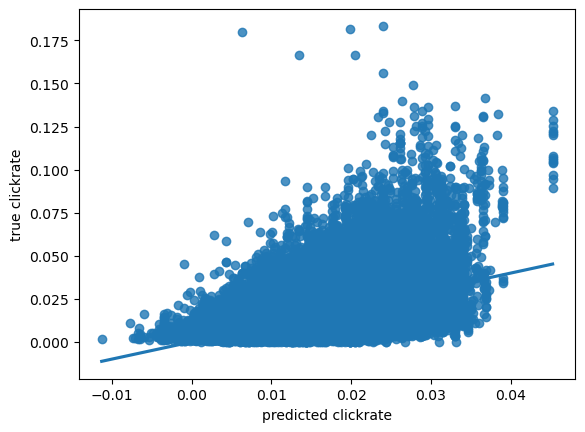

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
# print stuff. 
predictions = ridge_model.predict(stored_embeddings)
print(predictions.max())
# visualize real and predicted values
fig, ax = plt.subplots()
sns.regplot(x = predictions, y = df.clickrate, ax=ax)
ax.set(ylabel = 'true clickrate', xlabel = 'predicted clickrate')

## 2.Causal Model 

Implement Causal Model: + Reading
    - We divide every click rate by the article mean and the plug it in regression

In [9]:
#calculating mean per clickability_test_id and eyecatcher_id
df["means"] = df.groupby(["clickability_test_id","eyecatcher_id"])["clickrate"].transform("mean")
df.columns
df["adjusted_clickrate"] = df["clickrate"]/df["means"]
# set rows with 0 clicks -> adjusted clickrates NA - set to zero
df["adjusted_clickrate"] = df["adjusted_clickrate"].fillna(0)
print(df["adjusted_clickrate"].isna().sum())
adjusted_clickrate = torch.tensor(df.adjusted_clickrate.values)

0


In [10]:
# What do we do with headlines that did not get any clicks? 
# Will they just have an adjusted clickrate of zero?
df.loc[(df["clickrate"]/df["means"]).isna(), ['headline', 'eyecatcher_id', 'clicks', 'impressions', 'means', 'clickrate']]

,headline,eyecatcher_id,clicks,impressions,means,clickrate
8063,Folks in this city survive on $3 per day. He c...,54f63e1330663500262e0000,0,2433,0.0,0.0
9152,People all over the world have so many reasons...,550c68ad3862650024510000,0,1971,0.0,0.0
9155,"They made history, but history forgot them. Un...",550b296a3630330018200000,0,2034,0.0,0.0
11986,Here’s Pete Seeger Doing One Of The Songs He L...,5332fbd6a2fc90ead000245b,0,47,0.0,0.0
31719,This Unjust War Costs Us Nearly $4 Billion Eve...,5332b6da1fae79f09f0012e4,0,64,0.0,0.0
31720,This Unjust War Costs Us Nearly $4 Billion Eve...,5332bbcc1fae79f09f0058d7,0,69,0.0,0.0
31721,"Hey Barack, We're Blowing Billions On Busting ...",5332b6da1fae79f09f0012e4,0,66,0.0,0.0
31722,"Hey Barack, We're Blowing Billions On Busting ...",5332bbcc1fae79f09f0058d7,0,53,0.0,0.0
31724,To Say There Isn't Injustice Here Is Is As Big...,5332bbcd1fae79f09f0058de,0,323,0.0,0.0
33839,It Only Took Rachel Maddow 48 Seconds To Shut ...,5332bc921fae79f09f006ddc,0,1,0.0,0.0


## 2.1 Causal model with Ridge Regression 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(stored_embeddings, adjusted_clickrate, test_size=0.2)
causal_ridge_model =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
causal_ridge_model.fit(X_train, y_train)
causal_ridge_model.score(X_train,y_train)
causal_predictions_rg = causal_ridge_model.predict(X_test)
rmse = mean_squared_error(y_test, causal_predictions_rg)
print("Causal Ridge Regression MSE for click difference:", rmse)
print("Causal Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=causal_predictions_rg))
df["causal_predictions_ridge"] = causal_ridge_model.predict(stored_embeddings)

Causal Ridge Regression MSE for click difference: 0.047840957781797595
Causal Ridge Regression R2 for click difference: 0.030016315158696405


## 2.2 Causal model with Linear Regression

In [12]:
causal_linear_model =LinearRegression()
causal_linear_model.fit(X_train, y_train)
causal_linear_model.score(X_train,y_train)
causal_predictions_lm = causal_linear_model.predict(X_test)
rmse = mean_squared_error(y_test, causal_predictions_lm, squared=False)
print("Causal Linear Regression MSE for clicks:", rmse)
print("Causal Linear Regression R2 for clicks:", r2_score(y_true=y_test, y_pred=causal_predictions_lm))
df["causal_predictions_linear"] = causal_linear_model.predict(stored_embeddings)

Causal Linear Regression MSE for clicks: 0.21960700392856172
Causal Linear Regression R2 for clicks: 0.022184454007067145


## 3.1 Compare top / bottom 20 causal model with correlational model - Ridge Regression


In [13]:
from ipywidgets import widgets, Layout
from IPython import display


last20_pred = df.sort_values(["predictions_ridge"],ascending=True).loc[:,['headline']][:20]
last20_pred_causal = df.sort_values(["causal_predictions_ridge"],ascending=True).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(last20_pred.style.set_caption('Last 20 Ridge'))
    last20_pred.info()
with widget2:
    display.display(last20_pred_causal.style.set_caption('Last 20 Causal'))
    last20_pred_causal.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [14]:
#Checking for intersection
np.intersect1d(last20_pred.values,last20_pred_causal.values)

array(['You Know What Gets Bi-Partisan Support? Not Being Corrupt And Working Together. By A 2-1 Margin.'],
      dtype=object)

In [15]:
first20_pred = df.sort_values(["predictions_ridge"],ascending=False).loc[:,['headline']][:20]
first20_pred_causal = df.sort_values(["causal_predictions_ridge"],ascending=False).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(first20_pred.style.set_caption('First 20 Ridge'))
    first20_pred.info()
with widget2:
    display.display(first20_pred_causal.style.set_caption('First 20 Causal'))
    first20_pred_causal.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [16]:
np.intersect1d(first20_pred.values,first20_pred_causal.values)

array([], dtype=object)

## 3.1 Compare top / bottom 20 causal model with correlational model - Linear

In [17]:
last20_pred = df.sort_values(["predictions_linear"],ascending=True).loc[:,['headline']][:20]
last20_pred_causal = df.sort_values(["causal_predictions_linear"],ascending=True).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(last20_pred.style.set_caption('Last 20 Linear'))
    last20_pred.info()
with widget2:
    display.display(last20_pred_causal.style.set_caption('Last 20 Causal'))
    last20_pred_causal.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [18]:
#Checking for intersection
np.intersect1d(last20_pred.values,last20_pred_causal.values)

array(['You Know What Gets Bi-Partisan Support? Not Being Corrupt And Working Together. By A 2-1 Margin.'],
      dtype=object)

In [19]:
first20_pred = df.sort_values(["predictions_linear"],ascending=False).loc[:,['headline']][:20]
first20_pred_causal = df.sort_values(["causal_predictions_linear"],ascending=False).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(first20_pred.style.set_caption('First 20 Linear'))
    first20_pred.info()
with widget2:
    display.display(first20_pred_causal.style.set_caption('First 20 Causal'))
    first20_pred_causal.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [20]:
#Checking for intersection
np.intersect1d(first20_pred.values,first20_pred_causal.values)

array([], dtype=object)

## 4.1 Shapley Values Ridge Regression predicting Clickrate

In [21]:
# load the model

# here we also need embeddings - the whole thing is our model
model = SentenceTransformer(
    "sentence-transformers/all-mpnet-base-v2")

# this defines an explicit python function that takes a list of strings and outputs scores for each class
def f(x):
    embedding = model.encode(x)
    return ridge_model.predict(embedding)

In [22]:
method = "custom tokenizer"

# build an explainer by passing a transformers tokenizer
if method == "transformers tokenizer":
    explainer = shap.Explainer(f)

# build an explainer by explicitly creating a masker
elif method == "default masker":
    masker = shap.maskers.Text(r"\W")  # this will create a basic whitespace tokenizer
    explainer = shap.Explainer(f, masker)

# build a fully custom tokenizer
elif method == "custom tokenizer":
    import re

    def custom_tokenizer(s, return_offsets_mapping=True):
        """Custom tokenizers conform to a subset of the transformers API."""
        pos = 0
        offset_ranges = []
        input_ids = []
        for m in re.finditer(r"\W", s):
            start, end = m.span(0)
            offset_ranges.append((pos, start))
            input_ids.append(s[pos:start])
            pos = end
        if pos != len(s):
            offset_ranges.append((pos, len(s)))
            input_ids.append(s[pos:])
        out = {}
        out["input_ids"] = input_ids
        if return_offsets_mapping:
            out["offset_mapping"] = offset_ranges
        return out

    masker = shap.maskers.Text(custom_tokenizer)
    explainer = shap.Explainer(f, masker)

In [23]:
shap_values = explainer(df["headline"][:1])

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:20, 20.96s/it]                                     


In [24]:
ridge_model.predict(stored_embeddings[0].reshape(1,-1))

array([0.01435928])

In [25]:
shap.plots.text(shap_values)